<a href="https://colab.research.google.com/github/fabianoswald/EmbeddingKnowledge/blob/master/evalLEAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load

In [0]:
!pip install tensorflow==1.7.0
!pip install chars2vec
#!pip install keras==2.1.5

     |████████████████████████████████| 48.0MB 62kB/s 
     |████████████████████████████████| 3.1MB 58.0MB/s 
     |████████████████████████████████| 890kB 43.0MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp27-none-any.whl size=107220 sha256=65c261e24f6f08e9af11a5605f4de351d512a298a03febdbabb96be2d3891f20
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.7.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboa

In [0]:
import os, sys, pickle, re, string, itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, accuracy_score
import sklearn.metrics as metrics

import csv
import pdb
import operator

import chars2vec
import tensorflow as tf
from tensorflow.contrib import layers
import scipy.io as sio
from math import floor
from random import shuffle

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [0]:
!python --version
tf.__version__

Python 2.7.17


'1.7.0'

In [0]:
# load data

zero_shot_dec06 = "/content/drive/My Drive/data/aok/zero_shot_dec06.p"
zero_shot_dec06_emb= "/content/drive/My Drive/data/aok/zero_shot_dec06_emb.p"

multi_xx_dec06 = "/content/drive/My Drive/data/aok/multi_xx_dec06.p"
multi_xx_dec06_emb= "/content/drive/My Drive/data/aok/multi_xx_dec06_emb.p"

noisy_13_dec06 = "/content/drive/My Drive/data/aok/noisy_13_dec06.p"
noisy_13_dec06_emb= "/content/drive/My Drive/data/aok/noisy_13_dec06_emb.p"

noisy_63_dec06 = "/content/drive/My Drive/data/aok/noisy_63_dec06.p"
noisy_63_dec06_emb= "/content/drive/My Drive/data/aok/noisy_63_dec06_emb.p"

raw200_dec06 = "/content/drive/My Drive/data/aok/raw200_dec06.p"
raw200_dec06_emb= "/content/drive/My Drive/data/aok/raw200_dec06_emb.p"

dec06 = "/content/drive/My Drive/data/aok/dec06.p"
dec06_emb= "/content/drive/My Drive/data/aok/dec06_emb.p"

x = pickle.load(open(noisy_63_dec06, "rb"))

train, train_text, train_lab = x[0],x[1], x[2]
val, val_text, val_lab = x[3],x[4], x[5]
test, test_text, test_lab = x[6],x[7], x[8]
wordtoix, ixtoword, description_clean = x[9], x[10], x[11]

# load embeddings
eng_embeddings = pickle.load(open(noisy_63_dec06_emb, "rb"))

In [0]:
a=0;b=0;

for arr in val_lab:
    if len(np.unique(arr)) != 2:
        a+=1
    else:
        b+=1
print(a,b)

(0, 1504)


In [0]:
description_clean= [str(r) for r in description_clean]

In [0]:
len(description_clean)

63

In [0]:
eng_embeddings.shape

(12441, 300)

In [0]:
len(description_clean)

63

In [0]:
train_lab.shape

(12028, 63)

# LEAM

In [0]:
class Options(object):
    def __init__(self):
        self.GPUID = 0
        self.dataset = 'aok'
        self.fix_emb = True
        self.restore = True
        self.W_emb = None
        self.W_class_emb = None
        self.maxlen = 305
        self.n_words = None
        self.embed_size = 300
        self.lr = 1e-3
        self.batch_size = 10
        self.max_epochs = 10
        self.dropout = 0.5
        self.part_data = False
        self.portion = 1.0
        self.save_path = "./save/"
        self.log_path = "./log/"
        self.print_freq = 100
        self.valid_freq = 100

        self.optimizer = 'Adam'
        self.clip_grad = None
        self.class_penalty = 1.0
        self.ngram = 2
        self.H_dis = 300


    def __iter__(self):
        for attr, value in self.__dict__.iteritems():
            yield attr, value

opt= Options()

In [0]:
emb_file= eng_embeddings

opt.num_class = len(description_clean)
opt.class_name= description_clean

In [0]:
!ls

drive  sample_data


In [0]:
train_lab.shape

(12028, 63)

In [0]:
train_lab = np.array(train_lab, dtype='float32')
val_lab = np.array(val_lab, dtype='float32')
test_lab = np.array(test_lab, dtype='float32')
opt.n_words = len(ixtoword)
if opt.part_data:
    #np.random.seed(123)
    train_ind = np.random.choice(len(train), int(len(train)*opt.portion), replace=False)
    train = [train[t] for t in train_ind]
    train_lab = [train_lab[t] for t in train_ind]

os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.GPUID)

print(dict(opt))
print('Total words: %d' % opt.n_words)

{'restore': True, 'fix_emb': True, 'log_path': './log/', 'dataset': 'aok', 'part_data': False, 'max_epochs': 10, 'clip_grad': None, 'embed_size': 300, 'class_name': ['anziehen ausziehen von kompressionsstruempfen', 'injektion', 'abnehmen anlegen von kompressionsverbaenden', 'dekubitusbehandlung', 'infusion', 'leistungsgruppe einzelleistung', 'blutdruckmessen', 'eisbeutel kaeltetraeger verabreichen', 'hilfe bei koerperpflege', 'stuetzkorsett anlegen von', 'tages und wochenplanung hilfe bei', 'umschlaege verabreichen von', 'vorbeugungsma nahmen', 'absaugen', 'anus praeter versorgung', 'anus praeter wechsel', 'arzneien verabreichen und ueberwachen', 'gabe von salbe und tropfen augen', 'bewegungsuebungen', 'blutzucker messen', 'drainagen berwachung von', 'einlauf', 'einreibungen', 'fluessigkeitsbilanzierungen', 'infusionen bis minuten', 'inhalationen', 'injektionen bis besuch', 'instillation', 'katheterisierung', 'ohren gabe von salben und tropfen', 'sprechuebungen', 'stomaversorgung', 'wo

In [0]:
def load_class_embedding( wordtoidx, opt):
    print("load class embedding")
    name_list = [ k.lower().split(' ') for k in opt.class_name]
    id_list = [ [ wordtoix[i] for i in l] for l in name_list]
    value_list = [ [ opt.W_emb[i] for i in l]    for l in id_list]
    value_mean = [ np.mean(l,0)  for l in value_list]
    return np.asarray(value_mean)

In [0]:
try:
    #opt.W_emb = np.array(cPickle.load(open(embpath, 'rb')),dtype='float32')
    #opt.W_emb = np.squeeze(opt.W_emb, axis=0)
    opt.W_emb= emb_file
    opt.W_class_emb =  load_class_embedding( wordtoix, opt)
except IOError:
    print('No embedding file found.')
    opt.fix_emb = False

load class embedding


In [0]:
opt.W_emb.shape

(12441, 300)

In [0]:
  def embedding(features, opt, prefix='', is_reuse=None):
    """Customized function to transform batched x into embeddings."""
    # Convert indexes of words into embeddings.
    with tf.variable_scope(prefix + 'embed', reuse=tf.AUTO_REUSE):
        if opt.fix_emb:
            assert (hasattr(opt, 'W_emb'))
            assert (np.shape(np.array(opt.W_emb)) == (opt.n_words, opt.embed_size))
            W = tf.get_variable('W', initializer=opt.W_emb, trainable=True)
            print("initialize word embedding finished")
        else:
            weightInit = tf.random_uniform_initializer(-0.001, 0.001)
            W = tf.get_variable('W', [opt.n_words, opt.embed_size], initializer=weightInit)
    if hasattr(opt, 'relu_w') and opt.relu_w:
        W = tf.nn.relu(W)
    
    word_vectors = tf.nn.embedding_lookup(W, features)

    return word_vectors, W

def embedding_class(features, opt, prefix='', is_reuse=None):
    """Customized function to transform batched y into embeddings."""
    # Convert indexes of words into embeddings.
    with tf.variable_scope(prefix + 'embed', reuse=tf.AUTO_REUSE):
        if opt.fix_emb:
            assert (hasattr(opt, 'W_class_emb'))
            W = tf.get_variable('W_class', initializer=opt.W_class_emb, trainable=True)
            print("initialize class embedding finished")
        else:
            weightInit = tf.random_uniform_initializer(-0.001, 0.001)
            W = tf.get_variable('W_class', [opt.num_class, opt.embed_size], initializer=weightInit)
    if hasattr(opt, 'relu_w') and opt.relu_w:
        W = tf.nn.relu(W)
    word_vectors = tf.nn.embedding_lookup(W, features)

    return word_vectors, W

In [0]:
def partial_softmax(logits, weights, dim, name,):
    with tf.name_scope('partial_softmax'):
        exp_logits = tf.exp(logits)
        if len(exp_logits.get_shape()) == len(weights.get_shape()):
            exp_logits_weighted = tf.multiply(exp_logits, weights)
        else:
            exp_logits_weighted = tf.multiply(exp_logits, tf.expand_dims(weights, -1))
        exp_logits_sum = tf.reduce_sum(exp_logits_weighted, axis=dim, keepdims=True)
        partial_softmax_score = tf.div(exp_logits_weighted, exp_logits_sum, name=name)
        return partial_softmax_score

In [0]:
def att_emb_ngram_encoder_cnn(x_emb, x_mask, W_class, W_class_tran, opt):
    x_mask = tf.expand_dims(x_mask, axis=-1) # b * s * 1
    x_emb_0 = tf.squeeze(x_emb,) # b * s * e
    x_emb_1 = tf.multiply(x_emb_0, x_mask) # b * s * e

    H = tf.contrib.layers.conv2d(x_emb_0, num_outputs=opt.embed_size,kernel_size=[10], padding='SAME',activation_fn=tf.nn.relu) #b * s *  c


    G = tf.contrib.keras.backend.dot(H, W_class_tran) # b * s * c
    Att_v_max = partial_softmax(G, x_mask, 1, 'Att_v_max') # b * s * c

    x_att = tf.contrib.keras.backend.batch_dot(tf.transpose(H,[0,2,1]), Att_v_max)
    H_enc = tf.squeeze(x_att)
    return H_enc

In [0]:
def discriminator_0layer(H, opt, dropout, prefix='', num_outputs=1, is_reuse=None):
    H = tf.squeeze(H)
    biasInit = tf.constant_initializer(0.001, dtype=tf.float32)
    logits = layers.linear(tf.nn.dropout(H, keep_prob=dropout), num_outputs=num_outputs, biases_initializer=biasInit,
                           scope=prefix + 'dis', reuse=tf.AUTO_REUSE)
    return logits

In [0]:
def emb_classifier(x, x_mask, y, dropout, opt, class_penalty):
    # comment notation
    #  b: batch size, s: sequence length, e: embedding dim, c : num of class
    x_emb, W_norm = embedding(x, opt)  #  b * s * e
    x_emb=tf.cast(x_emb,tf.float32)
    W_norm=tf.cast(W_norm,tf.float32)
    y_pos = tf.argmax(y, -1)
    y_emb, W_class = embedding_class(y_pos, opt, 'class_emb') # b * e, c * e
    y_emb=tf.cast(y_emb,tf.float32)
    W_class=tf.cast(W_class,tf.float32)
    W_class_tran = tf.transpose(W_class, [1,0]) # e * c
    x_emb = tf.expand_dims(x_emb, 3)  # b * s * e * 1
    H_enc = att_emb_ngram_encoder_cnn(x_emb, x_mask, W_class, W_class_tran, opt)

    H_enc_list= tf.unstack(H_enc, axis=-1)
    logits_list = []
    for i, ih in enumerate(H_enc_list):
        logits_list.append(discriminator_0layer(ih, opt, dropout, prefix='classify_{}'.format(i), num_outputs=1, is_reuse=False) )

    logits = tf.concat(logits_list,-1)
    prob = tf.nn.softmax(logits)
    # class_y = tf.constant(name='class_y', shape=[opt.num_class, opt.num_class], dtype=tf.float32, value=np.identity(opt.num_class),)
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))

    global_step = tf.Variable(0, trainable=False)
    train_op = layers.optimize_loss(
        loss,
        global_step=global_step,
        optimizer=opt.optimizer,
        learning_rate=opt.lr)

    return accuracy, loss, train_op, W_norm, global_step, logits, prob

In [0]:
    with tf.device('/gpu:1'):
        x_ = tf.placeholder(tf.int32, shape=[opt.batch_size, opt.maxlen],name='x_')
        x_mask_ = tf.placeholder(tf.float32, shape=[opt.batch_size, opt.maxlen],name='x_mask_')
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        y_ = tf.placeholder(tf.float32, shape=[opt.batch_size, opt.num_class],name='y_')
        class_penalty_ = tf.placeholder(tf.float32, shape=())
        accuracy_, loss_, train_op, W_norm_, global_step, logits_, prob_ = emb_classifier(x_, x_mask_, y_, keep_prob, opt, class_penalty_)
    uidx = 0
    max_val_accuracy = 0.
    max_test_accuracy = 0.
    max_val_auc_mean = 0.
    max_test_auc_mean = 0.

initialize word embedding finished
initialize class embedding finished
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [0]:
config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True, )
config.gpu_options.allow_growth = True
np.set_printoptions(precision=3)
np.set_printoptions(threshold=np.inf)
saver = tf.train.Saver()

In [0]:
def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size
    return zip(range(len(minibatches)), minibatches)

In [0]:
def prepare_data_for_emb(seqs_x, opt):
    maxlen = opt.maxlen
    lengths_x = [len(s) for s in seqs_x]
    if maxlen != None:
        new_seqs_x = []
        new_lengths_x = []
        for l_x, s_x in zip(lengths_x, seqs_x):
            if l_x < maxlen:
                new_seqs_x.append(s_x)
                new_lengths_x.append(l_x)
            else:
                new_seqs_x.append(s_x[:maxlen])
                new_lengths_x.append(maxlen)
        lengths_x = new_lengths_x
        seqs_x = new_seqs_x

        if len(lengths_x) < 1:
            return None, None

    n_samples = len(seqs_x)
    maxlen_x = np.max(lengths_x)
    x = np.zeros((n_samples, maxlen)).astype('int32')
    x_mask = np.zeros((n_samples, maxlen)).astype('float32')
    for idx, s_x in enumerate(seqs_x):
        x[idx, :lengths_x[idx]] = s_x
        x_mask[idx, :lengths_x[idx]] = 1. # change to remove the real END token
    return x, x_mask

In [0]:
def intersect_size(yhat, y, axis):
    #axis=0 for label-level union (macro). axis=1 for instance-level
    return np.logical_and(yhat, y).sum(axis=axis).astype(float)
def macro_precision(yhat, y):
    num = intersect_size(yhat, y, 0) / (yhat.sum(axis=0) + 1e-10)
    return np.mean(num)

def macro_recall(yhat, y):
    num = intersect_size(yhat, y, 0) / (y.sum(axis=0) + 1e-10)
    return np.mean(num)
def macro_f1(yhat, y):
    prec = macro_precision(yhat, y)
    rec = macro_recall(yhat, y)
    if prec + rec == 0:
        f1 = 0.
    else:
        
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

def precision_at_k(yhat_raw, y, k):
    #num true labels in top k predictions / k
    sortd = np.argsort(yhat_raw)[:,::-1]
    topk = sortd[:,:k]

    #get precision at k for each example
    vals = []
    for i, tk in enumerate(topk):
        if len(tk) > 0:
            num_true_in_top_k = y[i,tk].sum()
            denom = len(tk)
            vals.append(num_true_in_top_k / float(denom))

    return np.mean(vals)

def micro_precision(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / yhatmic.sum(axis=0)

def micro_recall(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / ymic.sum(axis=0)

def micro_f1(yhatmic, ymic):
    prec = micro_precision(yhatmic, ymic)
    rec = micro_recall(yhatmic, ymic)

    if prec + rec == 0:
        f1 = 0.
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

In [0]:
def tensors_key_in_file(file_name):
    """Return tensors key in a checkpoint file.
    Args:
    file_name: Name of the checkpoint file.
    """
    try:
        reader = pywrap_tensorflow.NewCheckpointReader(file_name)
        return reader.get_variable_to_shape_map()
    except Exception as e:  # pylint: disable=broad-except
        print(str(e))
        return None

# Training

In [0]:
opt.save_path= '/content/save/73_model'
opt.save_path

'/content/save/73_model'

In [0]:
    with tf.Session(config=config) as sess:
        train_writer = tf.summary.FileWriter(opt.log_path + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(opt.log_path + '/test', sess.graph)
        sess.run(tf.global_variables_initializer())
        if opt.restore:
            try:
                t_vars = tf.trainable_variables()
                save_keys = tensors_key_in_file(opt.save_path)
                ss = set([var.name for var in t_vars]) & set([s + ":0" for s in save_keys.keys()])
                cc = {var.name: var for var in t_vars}
                # only restore variables with correct shape
                ss_right_shape = set([s for s in ss if cc[s].get_shape() == save_keys[s[:-2]]])

                loader = tf.train.Saver(var_list=[var for var in t_vars if var.name in ss_right_shape])
                loader.restore(sess, opt.save_path)

                print("Loading variables from '%s'." % opt.save_path)
                print("Loaded variables:" + str(ss))

            except:
                print("No saving session, using random initialization")
                sess.run(tf.global_variables_initializer())

        try:
            for epoch in range(opt.max_epochs):
                print("Starting epoch %d" % epoch)
                kf = get_minibatches_idx(len(train), opt.batch_size, shuffle=True)
                for _, train_index in kf:
                    uidx += 1
                    sents = [train[t] for t in train_index]
                    x_labels = [train_lab[t] for t in train_index]
                    x_labels = np.array(x_labels)
                    x_labels = x_labels.reshape((len(x_labels), opt.num_class))

                    x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
                    _, loss, step,  = sess.run([train_op, loss_, global_step], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout, class_penalty_:opt.class_penalty})

                    if uidx % opt.valid_freq == 0:
                        train_correct = 0.0
                        # sample evaluate accuaccy on 100 sample data
                        kf_train = get_minibatches_idx(100, opt.batch_size, shuffle=True)
                        for _, train_index in kf_train:
                            train_sents = [train[t] for t in train_index]
                            train_labels = [train_lab[t] for t in train_index]
                            train_labels = np.array(train_labels)
                            train_labels = train_labels.reshape((len(train_labels), opt.num_class))
                            x_train_batch, x_train_batch_mask = prepare_data_for_emb(train_sents, opt)
                            train_accuracy = sess.run(accuracy_, feed_dict={x_: x_train_batch, x_mask_: x_train_batch_mask, y_: train_labels, keep_prob: 1.0, class_penalty_:0.0})

                            train_correct += train_accuracy * len(train_index)

                        train_accuracy = train_correct / 100

                        print("Iteration %d: Training loss %f " % (uidx, loss))
                        print("Train accuracy %f " % train_accuracy)

                        val_correct = 0.0
                        val_y = []
                        val_logits_list = []
                        val_prob_list = []
                        val_true_list = []

                        kf_val = get_minibatches_idx(len(val), opt.batch_size, shuffle=True)
                        for _, val_index in kf_val:
                            val_sents = [val[t] for t in val_index]
                            val_labels = [val_lab[t] for t in val_index]
                            val_labels = np.array(val_labels)
                            val_labels = val_labels.reshape((len(val_labels), opt.num_class))
                            x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)
                            val_accuracy, val_logits, val_probs = sess.run([accuracy_, logits_, prob_], feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                                y_: val_labels, keep_prob: 1.0,
                                class_penalty_:0.0                                         })

                            val_correct += val_accuracy * len(val_index)
                            val_y += np.argmax(val_labels, axis=1).tolist()
                            val_logits_list += val_logits.tolist()
                            val_prob_list += val_probs.tolist()
                            val_true_list += val_labels.tolist()

                        val_accuracy = val_correct / len(val)
                        val_logits_array = np.asarray(val_logits_list)
                        val_prob_array = np.asarray(val_prob_list)
                        val_true_array = np.asarray(val_true_list)
                        val_auc_list = []

                        val_hamming = hamming_loss(y_true=val_true_array, y_pred= np.where(np.array(val_prob_list) > 0.5, 1, 0))
                        val_accuracy_fraction = accuracy_score(y_true=val_true_array, y_pred= np.where(np.array(val_prob_list) > 0.5, 1, 0))
                        val_accuracy_number = accuracy_score(y_true=val_true_array, y_pred= np.where(np.array(val_prob_list) > 0.5, 1, 0),normalize=False)


                        #val_auc_micro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='micro')
                        #val_auc_macro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='macro')
                        #for i in range(opt.num_class):
                        #    if np.max(val_true_array[:,i] > 0):
                        #        val_auc = roc_auc_score(y_true = val_true_array[:,i], y_score= val_logits_array[:,i],)
                        #        val_auc_list.append(val_auc)
                        #val_auc_mean = np.mean(val_auc)

                        print("Validation accuracy %f " % val_accuracy)
                        #print("val auc macro %f micro %f " % (val_auc_macro, val_auc_micro))
                        print("val hamming %f " % (val_hamming))
                        print("val accuracy %f total %f" % (val_accuracy_fraction, val_accuracy_number))

                        if True:
                            test_correct = 0.0
                            test_y = []
                            test_logits_list = []
                            test_prob_list = []
                            test_true_list = []

                            kf_test = get_minibatches_idx(len(test), opt.batch_size, shuffle=True)
                            for _, test_index in kf_test:
                                test_sents = [test[t] for t in test_index]
                                test_labels = [test_lab[t] for t in test_index]
                                test_labels = np.array(test_labels)
                                test_labels = test_labels.reshape((len(test_labels), opt.num_class))
                                x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                                test_accuracy, test_logits, test_probs= sess.run([accuracy_, logits_, prob_],feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,y_: test_labels, keep_prob: 1.0, class_penalty_: 0.0})

                                test_correct += test_accuracy * len(test_index)

                                test_correct += test_accuracy * len(test_index)
                                test_y += np.argmax(test_labels, axis=1).tolist()
                                test_logits_list += test_logits.tolist()
                                test_prob_list += test_probs.tolist()
                                test_true_list += test_labels.tolist()
                            test_accuracy = test_correct / len(test)
                            test_logits_array = np.asarray(test_logits_list)
                            test_prob_array = np.asarray(test_prob_list)
                            test_true_array = np.asarray(test_true_list)
                            test_auc_list = []

                            test_hamming = metrics.hamming_loss(y_true=test_true_array, y_pred = np.where(np.array(test_prob_list) > 0.5, 1, 0))

                            test_accuracy_fraction = accuracy_score(y_true=test_true_array, y_pred =np.where(np.array(test_prob_list) > 0.5, 1, 0))
                            test_accuracy_number = accuracy_score(y_true=test_true_array, y_pred =np.where(np.array(test_prob_list) > 0.5, 1, 0),normalize=False)


                         #   test_auc_micro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='micro')
                         #   test_auc_macro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='macro')

                            test_f1_micro = micro_f1(test_prob_array.ravel() >0.5, test_true_array.ravel(), )
                            test_f1_macro = macro_f1(test_prob_array > 0.5, test_true_array, )
                            test_p5 = precision_at_k(test_logits_array, test_true_array , 5)

                          #  for i in range(opt.num_class):
                          #      if np.max(test_true_array[:,i] > 0):
                          #          test_auc = roc_auc_score(y_true = test_true_array[:,i], y_score= test_logits_array[:,i],)
                          #          test_auc_list.append(test_auc)

                          #  test_auc_mean = np.mean(test_auc)
                          #  print("Test auc macro %f micro %f " % (test_auc_macro, test_auc_micro))
                            print("Test f1 macro %f micro %f " % (test_f1_macro, test_f1_micro))
                            print("Test hamming %f " % (test_hamming))
                            print("Test accuracy %f accuracy total %f " % (test_accuracy_fraction, test_accuracy_number))
                            print("P5 %f" % test_p5)
                            # max_test_accuracy = test_accuracy
                            #max_test_auc_mean = test_auc_mean
                            # print("Test accuracy %f " % test_accuracy)
                            # max_test_accuracy = test_accuracy

                # print("Epoch %d: Max Test accuracy %f" % (epoch, max_test_accuracy))
                #print("Epoch %d: Max Test auc %f" % (epoch, max_test_auc_mean))
                saver.save(sess, opt.save_path, global_step=epoch)
            print("Max Test accuracy %f " % max_test_accuracy)

        except KeyboardInterrupt:
            print('Training interupted')
            print("Max Test accuracy %f " % max_test_accuracy)


global name 'pywrap_tensorflow' is not defined
No saving session, using random initialization
Starting epoch 0
Iteration 100: Training loss 0.060569 
Train accuracy 0.470000 
Validation accuracy 0.436170 
val hamming 0.017354 
val accuracy 0.290667 total 436.000000
Test f1 macro 0.033950 micro 0.364208 
Test hamming 0.019249 
Test accuracy 0.256000 accuracy total 384.000000 
P5 0.198800
Iteration 200: Training loss 0.067918 
Train accuracy 0.590000 
Validation accuracy 0.559840 
val hamming 0.013968 
val accuracy 0.414667 total 622.000000
Test f1 macro 0.067641 micro 0.477642 
Test hamming 0.016688 
Test accuracy 0.355333 accuracy total 533.000000 
P5 0.214267
Iteration 300: Training loss 0.028826 
Train accuracy 0.630000 
Validation accuracy 0.611037 
val hamming 0.012751 
val accuracy 0.458667 total 688.000000
Test f1 macro 0.080737 micro 0.532647 
Test hamming 0.015376 
Test accuracy 0.390000 accuracy total 585.000000 
P5 0.219600
Iteration 400: Training loss 0.017854 
Train accurac

# Attention Score

In [0]:
np.where(np.array(val_prob_list) > 0.8, 1, 0)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
func = lambda x: np.where(x>0.8,1,0)

b =[[1.234,2.454],[2.352,9.873]]
b = [list(map(func, i)) for i in val_prob_list]
b

[[array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0),
  array(0)],
 [array(0),
  array(0),
  array(0),
  array(0),
  array(0)

In [0]:
from sklearn.metrics import accuracy_score

def roc_auc_score_FIXED(y_true, y_pred, average):
    if len(np.unique(y_true)) != 2: # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred, average)

In [0]:
    with tf.Session(config=config) as sess:
        train_writer = tf.summary.FileWriter(opt.log_path + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(opt.log_path + '/test', sess.graph)
        sess.run(tf.global_variables_initializer())
        if opt.restore:
            try:
                t_vars = tf.trainable_variables()
                save_keys = tensors_key_in_file(opt.save_path)
                ss = set([var.name for var in t_vars]) & set([s + ":0" for s in save_keys.keys()])
                cc = {var.name: var for var in t_vars}
                # only restore variables with correct shape
                ss_right_shape = set([s for s in ss if cc[s].get_shape() == save_keys[s[:-2]]])

                loader = tf.train.Saver(var_list=[var for var in t_vars if var.name in ss_right_shape])
                loader.restore(sess, opt.save_path)

                print("Loading variables from '%s'." % opt.save_path)
                print("Loaded variables:" + str(ss))

            except:
                print("No saving session, using random initialization")
                sess.run(tf.global_variables_initializer())

        try:
            for epoch in range(opt.max_epochs):
                print("Starting epoch %d" % epoch)
                kf = get_minibatches_idx(len(train), opt.batch_size, shuffle=True)
                for _, train_index in kf:
                    uidx += 1
                    sents = [train[t] for t in train_index]
                    x_labels = [train_lab[t] for t in train_index]
                    x_labels = np.array(x_labels)
                    x_labels = x_labels.reshape((len(x_labels), opt.num_class))

                    x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
                    _, loss, step,  = sess.run([train_op, loss_, global_step], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout, class_penalty_:opt.class_penalty})

                    if uidx % opt.valid_freq == 0:
                        train_correct = 0.0
                        # sample evaluate accuaccy on 500 sample data
                        kf_train = get_minibatches_idx(100, opt.batch_size, shuffle=True)
                        for _, train_index in kf_train:
                            train_sents = [train[t] for t in train_index]
                            train_labels = [train_lab[t] for t in train_index]
                            train_labels = np.array(train_labels)
                            train_labels = train_labels.reshape((len(train_labels), opt.num_class))
                            x_train_batch, x_train_batch_mask = prepare_data_for_emb(train_sents, opt)
                            train_accuracy = sess.run(accuracy_, feed_dict={x_: x_train_batch, x_mask_: x_train_batch_mask, y_: train_labels, keep_prob: 1.0, class_penalty_:0.0})

                            train_correct += train_accuracy * len(train_index)

                        train_accuracy = train_correct / 100

                        print("Iteration %d: Training loss %f " % (uidx, loss))
                        print("Train accuracy %f " % train_accuracy)

                        val_correct = 0.0
                        val_y = []
                        val_logits_list = []
                        val_prob_list = []
                        val_true_list = []

                        kf_val = get_minibatches_idx(len(val), opt.batch_size, shuffle=True)
                        for _, val_index in kf_val:
                            val_sents = [val[t] for t in val_index]
                            val_labels = [val_lab[t] for t in val_index]
                            val_labels = np.array(val_labels)
                            val_labels = val_labels.reshape((len(val_labels), opt.num_class))
                            x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)
                            val_accuracy, val_logits, val_probs = sess.run([accuracy_, logits_, prob_], feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                                y_: val_labels, keep_prob: 1.0,
                                class_penalty_:0.0                                         })

                            val_correct += val_accuracy * len(val_index)
                            val_y += np.argmax(val_labels, axis=1).tolist()
                            val_logits_list += val_logits.tolist()
                            val_prob_list += val_probs.tolist()
                            val_true_list += val_labels.tolist()

                        val_accuracy = val_correct / len(val)
                        val_logits_array = np.asarray(val_logits_list)
                        val_prob_array = np.asarray(val_prob_list)
                        val_true_array = np.asarray(val_true_list)
                        val_auc_list = []

                        #print("y_true=",val_true_array, "y_pred=",np.around(val_logits_array,0))

                        val_hamming = metrics.hamming_loss(y_true=val_true_array, y_pred=np.around(val_prob_list,0))
                        
                        try:
                          val_auc_micro = roc_auc_score_FIXED(y_true=val_true_array, y_pred =val_logits_array,average='micro')
                        except ValueError:
                          pass
                        try:
                          val_auc_macro = roc_auc_score_FIXED(y_true=val_true_array, y_pred =val_logits_array,average='macro')
                        except ValueError:
                          pass
                        for i in range(opt.num_class):
                            if np.max(val_true_array[:,i] > 0):
                                val_auc = roc_auc_score(y_true = val_true_array[:,i], y_score= val_logits_array[:,i],)
                                val_auc_list.append(val_auc)
                        val_auc_mean = np.mean(val_auc)

                        # print("Validation accuracy %f " % val_accuracy)
                        print("val auc macro %f micro %f " % (val_auc_macro, val_auc_micro))
                        print("val hamming %f " % (val_hamming))

                        if True:
                            test_correct = 0.0
                            test_y = []
                            test_logits_list = []
                            test_prob_list = []
                            test_true_list = []

                            kf_test = get_minibatches_idx(len(test), opt.batch_size, shuffle=True)
                            for _, test_index in kf_test:
                                test_sents = [test[t] for t in test_index]
                                test_labels = [test_lab[t] for t in test_index]
                                test_labels = np.array(test_labels)
                                test_labels = test_labels.reshape((len(test_labels), opt.num_class))
                                x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                                test_accuracy, test_logits, test_probs= sess.run([accuracy_, logits_, prob_],feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,y_: test_labels, keep_prob: 1.0, class_penalty_: 0.0})

                                test_correct += test_accuracy * len(test_index)

                                test_correct += test_accuracy * len(test_index)
                                test_y += np.argmax(test_labels, axis=1).tolist()
                                test_logits_list += test_logits.tolist()
                                test_prob_list += test_probs.tolist()
                                test_true_list += test_labels.tolist()
                            test_accuracy = test_correct / len(test)
                            test_logits_array = np.asarray(test_logits_list)
                            test_prob_array = np.asarray(test_prob_list)
                            test_true_array = np.asarray(test_true_list)
                            test_auc_list = []

                            test_hamming = metrics.hamming_loss(y_true=test_true_array, y_pred =np.around(test_prob_list,0))

                            test_auc_micro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='micro')
                            test_auc_macro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='macro')

                            test_f1_micro = micro_f1(test_prob_array.ravel() >0.5, test_true_array.ravel(), )
                            test_f1_macro = macro_f1(test_prob_array > 0.5, test_true_array, )
                            test_p5 = precision_at_k(test_logits_array, test_true_array , 5)

                            for i in range(opt.num_class):
                                if np.max(test_true_array[:,i] > 0):
                                    test_auc = roc_auc_score(y_true = test_true_array[:,i], y_score= test_logits_array[:,i],)
                                    test_auc_list.append(test_auc)

                            test_auc_mean = np.mean(test_auc)
                            print("Test auc macro %f micro %f " % (test_auc_macro, test_auc_micro))
                            print("Test f1 macro %f micro %f " % (test_f1_macro, test_f1_micro))
                            print("Test f1 macro %f micro %f " % (test_f1_macro, test_f1_micro))
                            print("P5 %f" % test_p5)
                            print("Test Hamming %f" % test_hamming)
                            # max_test_accuracy = test_accuracy
                            max_test_auc_mean = test_auc_mean
                            # print("Test accuracy %f " % test_accuracy)
                            # max_test_accuracy = test_accuracy

                # print("Epoch %d: Max Test accuracy %f" % (epoch, max_test_accuracy))
                print("Epoch %d: Max Test auc %f" % (epoch, max_test_auc_mean))
                saver.save(sess, opt.save_path, global_step=epoch)
            print("Max Test accuracy %f " % max_test_accuracy)

        except KeyboardInterrupt:
            print('Training interupted')
            print("Max Test accuracy %f " % max_test_accuracy)

global name 'pywrap_tensorflow' is not defined
No saving session, using random initialization
Starting epoch 0
Iteration 600: Training loss 0.046945 
Train accuracy 0.470000 


NameError: ignored

In [0]:
    with tf.Session(config=config) as sess:
        train_writer = tf.summary.FileWriter(opt.log_path + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(opt.log_path + '/test', sess.graph)
        sess.run(tf.global_variables_initializer())
        if opt.restore:
            try:
                t_vars = tf.trainable_variables()
                save_keys = tensors_key_in_file(opt.save_path)
                ss = set([var.name for var in t_vars]) & set([s + ":0" for s in save_keys.keys()])
                cc = {var.name: var for var in t_vars}
                # only restore variables with correct shape
                ss_right_shape = set([s for s in ss if cc[s].get_shape() == save_keys[s[:-2]]])

                loader = tf.train.Saver(var_list=[var for var in t_vars if var.name in ss_right_shape])
                loader.restore(sess, opt.save_path)

                print("Loading variables from '%s'." % opt.save_path)
                print("Loaded variables:" + str(ss))

            except:
                print("No saving session, using random initialization")
                sess.run(tf.global_variables_initializer())

        try:
            for epoch in range(opt.max_epochs):
                print("Starting epoch %d" % epoch)
                kf = get_minibatches_idx(len(train), opt.batch_size, shuffle=True)
                for _, train_index in kf:
                    uidx += 1
                    sents = [train[t] for t in train_index]
                    x_labels = [train_lab[t] for t in train_index]
                    x_labels = np.array(x_labels)
                    x_labels = x_labels.reshape((len(x_labels), opt.num_class))

                    x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
                    _, loss, step,  = sess.run([train_op, loss_, global_step], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout, class_penalty_:opt.class_penalty})

                    if uidx % opt.valid_freq == 0:
                        train_correct = 0.0
                        # sample evaluate accuaccy on 500 sample data
                        kf_train = get_minibatches_idx(100, opt.batch_size, shuffle=True)
                        for _, train_index in kf_train:
                            train_sents = [train[t] for t in train_index]
                            train_labels = [train_lab[t] for t in train_index]
                            train_labels = np.array(train_labels)
                            train_labels = train_labels.reshape((len(train_labels), opt.num_class))
                            x_train_batch, x_train_batch_mask = prepare_data_for_emb(train_sents, opt)
                            train_accuracy = sess.run(accuracy_, feed_dict={x_: x_train_batch, x_mask_: x_train_batch_mask, y_: train_labels, keep_prob: 1.0, class_penalty_:0.0})

                            train_correct += train_accuracy * len(train_index)

                        train_accuracy = train_correct / 100

                        print("Iteration %d: Training loss %f " % (uidx, loss))
                        print("Train accuracy %f " % train_accuracy)

                        val_correct = 0.0
                        val_y = []
                        val_logits_list = []
                        val_prob_list = []
                        val_true_list = []

                        kf_val = get_minibatches_idx(len(val), opt.batch_size, shuffle=True)
                        for _, val_index in kf_val:
                            val_sents = [val[t] for t in val_index]
                            val_labels = [val_lab[t] for t in val_index]
                            val_labels = np.array(val_labels)
                            val_labels = val_labels.reshape((len(val_labels), opt.num_class))
                            x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)
                            val_accuracy, val_logits, val_probs = sess.run([accuracy_, logits_, prob_], feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                                y_: val_labels, keep_prob: 1.0,
                                class_penalty_:0.0                                         })

                            val_correct += val_accuracy * len(val_index)
                            val_y += np.argmax(val_labels, axis=1).tolist()
                            val_logits_list += val_logits.tolist()
                            val_prob_list += val_probs.tolist()
                            val_true_list += val_labels.tolist()

                        val_accuracy = val_correct / len(val)
                        val_logits_array = np.asarray(val_logits_list)
                        val_prob_array = np.asarray(val_prob_list)
                        val_true_array = np.asarray(val_true_list)
                        val_auc_list = []
                        #val_auc_micro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='micro')
                        #try: val_auc_macro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='macro'); 
                        #except ValueError: pass;
                        for i in range(opt.num_class):
                            if np.max(val_true_array[:,i] > 0):
                                val_auc = roc_auc_score(y_true = val_true_array[:,i], y_score= val_logits_array[:,i],)
                                val_auc_list.append(val_auc)
                        val_auc_mean = np.mean(val_auc)

                        print("Validation accuracy %f " % val_accuracy)
                        #print("val auc macro %f micro %f " % (val_auc_macro, val_auc_micro))

                        if True:
                            test_correct = 0.0
                            test_y = []
                            test_logits_list = []
                            test_prob_list = []
                            test_true_list = []

                            kf_test = get_minibatches_idx(len(test), opt.batch_size, shuffle=True)
                            for _, test_index in kf_test:
                                test_sents = [test[t] for t in test_index]
                                test_labels = [test_lab[t] for t in test_index]
                                test_labels = np.array(test_labels)
                                test_labels = test_labels.reshape((len(test_labels), opt.num_class))
                                x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                                test_accuracy, test_logits, test_probs= sess.run([accuracy_, logits_, prob_],feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,y_: test_labels, keep_prob: 1.0, class_penalty_: 0.0})

                                test_correct += test_accuracy * len(test_index)

                                test_correct += test_accuracy * len(test_index)
                                test_y += np.argmax(test_labels, axis=1).tolist()
                                test_logits_list += test_logits.tolist()
                                test_prob_list += test_probs.tolist()
                                test_true_list += test_labels.tolist()
                            test_accuracy = test_correct / len(test)
                            test_logits_array = np.asarray(test_logits_list)
                            test_prob_array = np.asarray(test_prob_list)
                            test_true_array = np.asarray(test_true_list)
                            test_auc_list = []
                            test_auc_micro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='micro')
                            try: test_auc_macro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='macro')
                            except ValueError: pass;

                            #test_f1_micro = micro_f1(test_prob_array.ravel() >0.5, test_true_array.ravel(), )
                            #test_f1_macro = macro_f1(test_prob_array > 0.5, test_true_array, )
                            #test_p5 = precision_at_k(test_logits_array, test_true_array , 5)

                            for i in range(opt.num_class):
                                if np.max(test_true_array[:,i] > 0):
                                    test_auc = roc_auc_score(y_true = test_true_array[:,i], y_score= test_logits_array[:,i],)
                                    test_auc_list.append(test_auc)

                            test_auc_mean = np.mean(test_auc)
                            #print("Test auc macro %f micro %f " % (test_auc_macro, test_auc_micro))
                            #print("Test f1 macro %f micro %f " % (test_f1_macro, test_f1_micro))
                            #print("P5 %f" % test_p5)
                            max_test_accuracy = test_accuracy
                            max_test_auc_mean = test_auc_mean
                            print("Test accuracy %f " % test_accuracy)
                            # max_test_accuracy = test_accuracy

                print("Epoch %d: Max Test accuracy %f" % (epoch, max_test_accuracy))
                print("Epoch %d: Max Test auc %f" % (epoch, max_test_auc_mean))
                saver.save(sess, opt.save_path, global_step=epoch)
            print("Max Test accuracy %f " % max_test_accuracy)

        except KeyboardInterrupt:
            print('Training interupted')
            print("Max Test accuracy %f " % max_test_accuracy)

global name 'pywrap_tensorflow' is not defined
No saving session, using random initialization
Starting epoch 0
Iteration 700: Training loss 0.039843 
Train accuracy 0.490000 
Validation accuracy 0.513963 
Test accuracy 0.933511 
Iteration 800: Training loss 0.034916 
Train accuracy 0.622000 
Validation accuracy 0.601729 
Training interupted
Max Test accuracy 0.933511 


In [0]:
opt.save_path

# Test


Both the **learned word and label embeddings are available** in the testing stage. 

We clarify that the label embeddings C of all class candidates Y are considered as the input in the testing stage; one should distinguish this from the use of groundtruth label y in prediction. 

For a text sequence X, one may feed it through the proposed pipeline for prediction: 


*   (i) f1: harvesting the word embeddings V
*   (ii) f2: V interacts with C to obtain G, pooled as β, which further attends V to derive z, and 
*   (iii) f3: assigning labels based on the tasks. 

To speed up testing, one may store G offline, and avoid its online computational cost.







  
  

In [0]:
# https://stackoverflow.com/questions/41265035/tensorflow-why-there-are-3-files-after-saving-the-model

with tf.Session(config=config) as sess:
    saver = tf.train.import_meta_graph('/content/save/model100-1.meta')
    saver.restore(sess, "/content/save/model100-1")

INFO:tensorflow:Restoring parameters from /content/save/model100-1


In [0]:

with tf.Session(config=config) as sess:
  new_saver = tf.train.import_meta_graph('/content/save/model100-1.meta')
  new_saver.restore(sess, tf.train.latest_checkpoint('/content/save'))

INFO:tensorflow:Restoring parameters from /content/save/model100-1


In [0]:
from tensorflow.python import pywrap_tensorflow
with tf.Session(config=config) as sess:
    train_writer = tf.summary.FileWriter(opt.log_path + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(opt.log_path + '/test', sess.graph)
    sess.run(tf.global_variables_initializer())

  
    t_vars = tf.trainable_variables()
    save_keys = tensors_key_in_file('/content/save/model-1')
    ss = set([var.name for var in t_vars]) & set([s + ":0" for s in save_keys.keys()])
    cc = {var.name: var for var in t_vars}
    # only restore variables with correct shape
    ss_right_shape = set([s for s in ss if cc[s].get_shape() == save_keys[s[:-2]]])

    loader = tf.train.Saver(var_list=[var for var in t_vars if var.name in ss_right_shape])
    loader.restore(sess, opt.save_path)

    print("Loading variables from '%s'." % opt.save_path)
    print("Loaded variables:" + str(ss))

INFO:tensorflow:Restoring parameters from /content/save/model-1
Loading variables from '/content/save/model-1'.
Loaded variables:set([u'lstm_1/recurrent_kernel:0', u'classify_31dis/biases:0', u'classify_42dis/biases:0', u'classify_6dis/biases:0', u'Adam_1/beta_2:0', u'classify_39dis/weights:0', u'classify_45dis/weights:0', u'classify_25dis/weights:0', u'classify_33dis/biases:0', u'lstm_1/bias:0', u'classify_29dis/weights:0', u'classify_13dis/biases:0', u'classify_41dis/weights:0', u'classify_36dis/biases:0', u'classify_23dis/biases:0', u'classify_6dis/weights:0', u'Adam_1/iterations:0', u'classify_9dis/weights:0', u'classify_26dis/weights:0', u'classify_44dis/biases:0', u'Adam_1/beta_1:0', u'classify_11dis/weights:0', u'classify_36dis/weights:0', u'classify_13dis/weights:0', u'classify_46dis/biases:0', u'classify_21dis/weights:0', u'dense_1/bias:0', u'classify_19dis/weights:0', u'classify_31dis/weights:0', u'classify_2dis/weights:0', u'classify_12dis/biases:0', u'classify_43dis/biases:

# Sklearn

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import sklearn.metrics
from sklearn.metrics import classification_report

In [0]:
df= df_dec02
df.text= df.text.apply(lambda x: ' '.join(x))
df.head(3)

,gpos,text
0,[255],medigabe aus als
1,"[518, 479]",von werden wochen krankenpflege von nicht werd...
2,"[322, 308, 387]",aus kompressionsverband anlegen abnehmen


In [0]:
type(df.text[0])

str

In [0]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df.gpos)
Y = multilabel_binarizer.transform(df.gpos)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df.text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [0]:
ros = RandomOverSampler(random_state=9000)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)

In [0]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, 
                                                                            Y_tfidf_resampled, 
                                                                            test_size=0.2, 
                                                                            random_state=9000)

In [0]:
X_tfidf_resampled

<161008x339 sparse matrix of type '<type 'numpy.float64'>'
	with 552600 stored elements in Compressed Sparse Row format>

In [0]:
Y.sum(axis=0)

array([   4,   59,    2,    6, 1422,  290,  389,    9,   15,    3,  110,
          3,   15,    2,   44,    2,   16,  869,  622,  512,    9,  544,
         58,   14,   20,    3,    3,    6, 1863,   28,  724,   60,  236,
         44,   23,    2,    2,    7,    3,    6,   89,  241,   74,    4,
         23,   23,    3,    6,   23,  105,    2,  985,    2,   76,   19,
          3,    2,    4])

Text(0.5,1,'class distribution in training set after resampling')

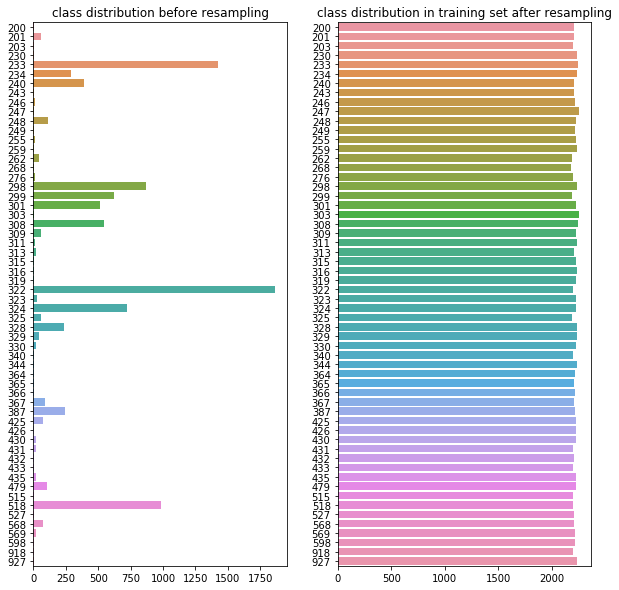

In [0]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)

g1 = sns.barplot(x=Y.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_test, orient = "h")
g2 = sns.barplot(x=y_train_tfidf.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_train, orient = "h")

g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

OneVsRest strategy to have one classifier for each class/label

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")  

In [0]:
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

('Clf: ', 'MultinomialNB')
Hamming loss: 0.00755361093442
Hamming score: 0.616442042937
---


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


('Clf: ', 'SGDClassifier')
Hamming loss: 0.00880594265938
Hamming score: 0.518585802124
---


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


('Clf: ', 'LogisticRegression')
Hamming loss: 0.00512551158741
Hamming score: 0.753058816223
---
('Clf: ', 'MultinomialNB')
Hamming loss: 0.00755361093442
Hamming score: 0.616442042937
---


In [0]:
!pip install git+http://github.com/scikit-learn/scikit-learn.git

  Cloning http://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-e50_xr
  Running command git clone -q http://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-e50_xr
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [0]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

clf = OneVsRestClassifier(lr)
clf.fit(x_train_tfidf, y_train_tfidf)
y_pred = clf.predict(x_test_tfidf)
accuracy_score(y_test_tfidf, y_pred)
multilabel_confusion_matrix(y_true, y_pred)

ImportError: ignored

In [0]:
from sklearn.metrics import classification_report

clf = OneVsRestClassifier(lr)
clf.fit(x_train_tfidf, y_train_tfidf)
y_pred = clf.predict(x_test_tfidf)
#accuracy_score(y_test_tfidf, y_pred)

target_names = ['200', '201', '203', '230', '233', '234', '240', '243', '246',
       '247', '248', '249', '255', '259', '262', '268', '276', '298',
       '299', '301', '303', '308', '309', '311', '313', '315', '316',
       '319', '322', '323', '324', '325', '328', '329', '330', '340',
       '344', '364', '365', '366', '367', '387', '425', '426', '430',
       '431', '432', '433', '435', '479', '515', '518', '527', '568',
       '569', '598', '918', '927']

print(classification_report(y_test_tfidf, y_pred, target_names=target_names))

#print(classification_report(y_true, y_pred, labels=[1, 2, 3]))

In [0]:
x_train_tfidf

<128806x339 sparse matrix of type '<type 'numpy.float64'>'
	with 441866 stored elements in Compressed Sparse Row format>

# Keras

In [0]:
# https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [0]:
#lab_clean= mlb.fit_transform(lab_clean)
sent_train, sent_test, lab_train, lab_test = train_test_split(sent_clean, lab_mlb_encoded, test_size=0.20, random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=len(vocab_clean.keys()))
tokenizer.fit_on_texts(sent_train)
print(sent_train[1])
print(type(sent_train[1]))

X_train = tokenizer.texts_to_sequences(sent_train)
X_test = tokenizer.texts_to_sequences(sent_test)
print(X_train)
print(type(X_train))

vocab_size = len(tokenizer.word_index) + 1

maxlen = 45

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[1])
print(type(X_train[1]))

['dekubitusbehandlung', 'mehr', 'als', 'wunden']
<type 'list'>
[[13, 2, 16, 8, 11, 3], [27, 23, 43, 98], [3], [5, 9, 18, 2], [9, 25, 1, 5, 18], [19, 14, 4, 7, 43, 10, 84, 19, 12], [4, 24], [1], [1], [11], [5, 109, 65], [5], [12], [26], [46, 20, 59, 90], [60, 47, 43, 6, 196], [7, 11, 34, 62], [51, 3, 15], [40, 26], [1, 17], [1, 48, 24], [1, 5, 24, 60], [14], [15, 41, 19], [150, 63], [29, 2, 44, 10, 74, 2, 53, 44, 24], [4, 27, 26, 92], [37, 8], [40, 12, 14], [95], [26], [22, 13, 16, 22, 11, 8, 22, 22, 25, 208, 22, 11, 35], [14], [21, 6], [26, 3], [5, 33, 18, 2, 98, 98, 5, 29, 39, 125, 32, 6, 2], [28, 7, 16, 9, 2, 15, 99], [2], [5, 109, 65], [18], [7], [4], [55, 2], [15, 77, 4, 24, 14], [21, 45, 82], [7], [77, 10], [10, 15, 7, 2, 30, 270, 11], [4, 14], [15, 4, 9, 14, 59], [4, 4], [20, 5, 46, 32], [15, 3, 1, 100, 12, 14, 18], [6], [6, 1, 8, 96, 39], [4, 1, 17], [1, 49, 170], [14], [50], [45], [3, 1, 5, 9, 18], [120], [12, 4, 171, 3], [1, 26], [4], [67, 6], [73, 14], [42, 13, 10], [196, 6, 

In [0]:

a= tokenizer.texts_to_sequences([sent_train[1]])
print(a)
flat_list = [item for sublist in a for item in sublist]
print(flat_list)
print(type(flat_list))

[[27, 23, 43, 98]]
[27, 23, 43, 98]
<type 'list'>


In [0]:
pad_list= pad_sequences(a, padding='post', maxlen=maxlen)
pad_list

array([[27, 23, 43, 98,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/data/glove/neu_vectors_glove_german.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
embedding_matrix.shape

(333, 300)

In [0]:
vocab_size

333

In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(58, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 45, 300)           99900     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 58)                7482      
Total params: 327,030
Trainable params: 227,130
Non-trainable params: 99,900
_________________________________________________________________
None


In [0]:
from keras.utils import plot_model
plot_model(model, 
           #to_file='model_plot4a.png', 
           show_shapes=True, show_layer_names=True)

In [0]:
X_train[0].shape

(45,)

In [0]:
history = model.fit(X_train, lab_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Train on 3790 samples, validate on 948 samples
Epoch 1/5
3790/3790 [==============================] - 10s 3ms/step - loss: 0.3900 - acc: 0.9544 - val_loss: 0.0956 - val_acc: 0.9749
Epoch 2/5
3790/3790 [==============================] - 9s 2ms/step - loss: 0.0886 - acc: 0.9742 - val_loss: 0.0827 - val_acc: 0.9749
Epoch 3/5
3790/3790 [==============================] - 9s 2ms/step - loss: 0.0844 - acc: 0.9742 - val_loss: 0.0818 - val_acc: 0.9749
Epoch 4/5
3790/3790 [==============================] - 9s 2ms/step - loss: 0.0839 - acc: 0.9742 - val_loss: 0.0817 - val_acc: 0.9749
Epoch 5/5
3790/3790 [==============================] - 9s 2ms/step - loss: 0.0835 - acc: 0.9744 - val_loss: 0.0817 - val_acc: 0.9749


In [0]:
score = model.evaluate(X_test, lab_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1185/1185 [==============================] - 1s 986us/step
('Test Score:', 0.08527957011124253)
('Test Accuracy:', 0.9739415109409059)


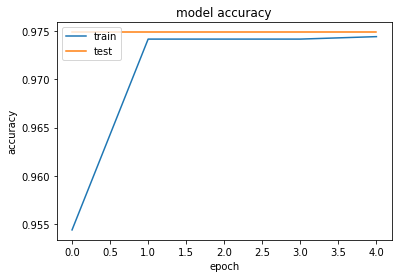

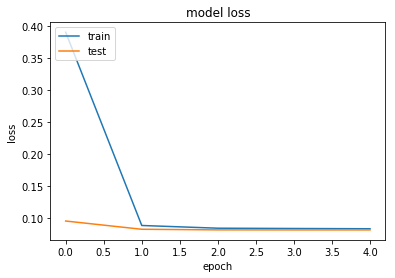

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:
X_test[0].shape

(45,)

In [0]:
np.array([X_test[0]]).shape

(1, 45)

In [0]:
model.predict(np.array([X_test[0]]))

array([[0.001, 0.011, 0.001, 0.001, 0.208, 0.043, 0.071, 0.005, 0.006,
        0.001, 0.019, 0.   , 0.003, 0.002, 0.009, 0.001, 0.004, 0.144,
        0.115, 0.084, 0.001, 0.003, 0.078, 0.01 , 0.002, 0.002, 0.001,
        0.001, 0.002, 0.001, 0.262, 0.004, 0.116, 0.009, 0.032, 0.008,
        0.007, 0.002, 0.003, 0.002, 0.002, 0.011, 0.033, 0.01 , 0.003,
        0.005, 0.005, 0.002, 0.003, 0.002, 0.018, 0.154, 0.001, 0.008,
        0.006, 0.001, 0.001, 0.001]], dtype=float32)

In [0]:
def predict_gpos(treatment):
  #print("treatment: ", treatment)
  treatment = tokenizer.texts_to_sequences([treatment])
  treatment = pad_sequences(treatment, padding='post', maxlen=45)
  #print(type(treatment))
  #print(treatment.shape)

  pred=model.predict(treatment)
  print("gpos: ",pred)
  #print(type(pred))

predict_gpos("bullshit")

('gpos: ', array([[0.001, 0.011, 0.001, 0.001, 0.208, 0.043, 0.071, 0.005, 0.006,
        0.001, 0.019, 0.   , 0.003, 0.002, 0.009, 0.001, 0.004, 0.144,
        0.115, 0.084, 0.001, 0.003, 0.078, 0.01 , 0.002, 0.002, 0.001,
        0.001, 0.002, 0.001, 0.262, 0.004, 0.116, 0.009, 0.032, 0.008,
        0.007, 0.002, 0.003, 0.002, 0.002, 0.011, 0.033, 0.01 , 0.003,
        0.005, 0.005, 0.002, 0.003, 0.002, 0.018, 0.154, 0.001, 0.008,
        0.006, 0.001, 0.001, 0.001]], dtype=float32))


In [0]:
print(mlb.classes_)

['201' '230' '233' '234' '240' '243' '246' '247' '248' '249' '255' '262'
 '268' '276' '298' '299' '301' '302' '308' '309' '311' '313' '315' '316'
 '319' '320' '322' '323' '324' '325' '328' '329' '330' '344' '364' '367'
 '387' '425' '426' '430' '431' '433' '435' '479' '518' '527' '568']


In [0]:
for line in lab_desc_clean:
  print(line)

201 blutdruckmessen
230 absaugen
233 arzneien verabreichen und ueberwachen
234 gabe von salbe und tropfen augen
240 blutzucker messen
243 dekubitusbehandlung und versorgung
246 drainagen berwachung von
247 einlauf
248 einreibungen
249 fluessigkeitsbilanzierungen
255 inhalationen
262 katheterisierung
268 ohren gabe von salben und tropfen
276 stomaversorgung
298 anziehen von kompressionsstruempfen
299 ausziehen von kompressionsstruempfen
301 insulininjektion
302 nase gabe von salben und tropfen bzw spuelung
308 kompressionsverbaende
309 versorgung bei perkutaner edoskopischer gastrostomie
311 richten von injektionen
313 versorgung eines suprapubischen katheters
315 digitale enddarmausraeumung
316 mischung mehrerer infusionen bei parenteralem zugang
319 venenkatheter pflege des zentralen
320 krankenbeobachtung spezielle
322 anlegen und wechseln von wundverbaenden
323 stuetzende und stabilisierende verbaende anlegen von
324 injektion
325 injektion
328 dekubitusbehandlung grad
329 dekubitus

In [0]:
def check(test_doc):
  predict_gpos(test_doc)
  print(test_doc)

In [0]:
check(sent_test[1])

('gpos: ', array([[0.006, 0.002, 0.256, 0.037, 0.059, 0.003, 0.001, 0.007, 0.013,
        0.002, 0.002, 0.006, 0.005, 0.002, 0.147, 0.12 , 0.066, 0.007,
        0.097, 0.003, 0.006, 0.006, 0.002, 0.002, 0.002, 0.001, 0.26 ,
        0.004, 0.127, 0.005, 0.027, 0.006, 0.003, 0.003, 0.004, 0.023,
        0.032, 0.003, 0.003, 0.003, 0.003, 0.004, 0.008, 0.007, 0.132,
        0.005, 0.008]], dtype=float32))
['lotun', 'gabe', 'von', 'augentropfen', 'elenalkombi', 'bei']


In [0]:
sent_test[1]

['lotun', 'gabe', 'von', 'augentropfen', 'elenalkombi', 'bei']

In [0]:
lab_test[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0])